# 0.1 Imports

In [1]:
import numpy as np
import pandas as pd


import scipy.stats as stats
from itertools import combinations
from statsmodels.stats.gof import chisquare_effectsize
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.power import GofChisquarePower, TTestIndPower


# 1.0 Load Data

In [2]:
data = {'variant' : ['interact', 'connect', 'learn', 'help', 'services'],
        'visits' : [10283, 2742, 2747, 3180, 2064],
        'clicks_all' : [3714, 1587, 1652, 1717, 1348],
        'clicks_link' : [42, 53, 21, 38, 45]}

df = pd.DataFrame( data )
df['conversion'] = df['clicks_link'] / df['clicks_all']
df

,variant,visits,clicks_all,clicks_link,conversion
0,interact,10283,3714,42,0.011309
1,connect,2742,1587,53,0.033396
2,learn,2747,1652,21,0.012712
3,help,3180,1717,38,0.022132
4,services,2064,1348,45,0.033383


# 2.0 Design de Experimentos

## 2.1 Formulação da Hipótese

In [3]:
# H0: Não há nenhuma diferença entre o CTR das variantes da página
# H1: Há nenhuma diferença entre o CTR das variantes da página

# Teste Bi-Caudal

## 2.2 Parâmetros do Experimento

In [4]:
k = len( df['clicks_all'])
dist_atual = df['clicks_link'] / df['clicks_link'].sum()
dist_esperada = [ 1/k ] * k

In [5]:
alpha = 0.05
power = 0.8
effect_size = chisquare_effectsize( dist_esperada, dist_atual )

""" sample_size = GofChisquarePower().solve_power(
                                effect_size=effect_size,
                                alpha=alpha,
                                power=power,
                                n_bins= (2 - 1)*( 5 - 1 )
)

sample_size = np.ceil(sample_size).astype( int )
 """

sample_size = TTestIndPower().solve_power(
                                effect_size=effect_size,
                                alpha=alpha,
                                power=power
)

sample_size = np.ceil(sample_size).astype( int )

print(f'Tamanho de amostra mínimo por variante: {sample_size}')
print(f'Tamanho de amostra total: {k*sample_size}')

Tamanho de amostra mínimo por variante: 222
Tamanho de amostra total: 1110


# 3.0 Aplicação do Teste Chi Squared

In [6]:
df['noclicks_link'] = df['clicks_all'] - df['clicks_link']

In [7]:
data = df[['variant', 'clicks_link', 'noclicks_link']].head()
data = data.set_index( 'variant' )
data

,clicks_link,noclicks_link
variant,,
interact,42,3672
connect,53,1534
learn,21,1631
help,38,1679
services,45,1303


In [8]:
chi2, p_value, dof, ex = stats.chi2_contingency(data)
print(f'Chi2: {chi2} -- p-value: {p_value}')

Chi2: 46.33660181942126 -- p-value: 2.0959498129984563e-09


# 4.0 Post-hoc

In [34]:
all_combinations = list ( combinations ( data.index, 2 ) ) 
p_values = []

for comb in all_combinations:
    df_comb = data[ (data.index == comb[0]) | (data.index == comb[1]) ]
    chi2, p_value, dof, ex = stats.chi2_contingency(df_comb)
    
    p_values.append( p_value )
    print(comb)

# correção de Bonferroni
reject_list, correct_p_value, _, _ = multipletests( p_values, method = 'bonferroni')

('interact', 'connect')
('interact', 'learn')
('interact', 'help')
('interact', 'services')
('connect', 'learn')
('connect', 'help')
('connect', 'services')
('learn', 'help')
('learn', 'services')
('help', 'services')


In [41]:
for comb , p_val, corr_p_val, reject in zip (all_combinations, p_values, correct_p_value, reject_list):
    print(f'\n{comb}: p_value:{p_val}; correct_p_value:{corr_p_val}; Reject:{reject}')
    


('interact', 'connect'): p_value:5.3676772349808135e-08; correct_p_value:5.367677234980813e-07; Reject:True

('interact', 'learn'): p_value:0.7616980743361713; correct_p_value:1.0; Reject:False

('interact', 'help'): p_value:0.0031030587017400212; correct_p_value:0.03103058701740021; Reject:True

('interact', 'services'): p_value:1.798089447385411e-07; correct_p_value:1.7980894473854111e-06; Reject:True

('connect', 'learn'): p_value:0.00013292868361715983; correct_p_value:0.0013292868361715984; Reject:True

('connect', 'help'): p_value:0.06144184057612575; correct_p_value:0.6144184057612575; Reject:False

('connect', 'services'): p_value:1.0; correct_p_value:1.0; Reject:False

('learn', 'help'): p_value:0.0508958228881819; correct_p_value:0.5089582288818191; Reject:False

('learn', 'services'): p_value:0.00020374035733741825; correct_p_value:0.0020374035733741825; Reject:True

('help', 'services'): p_value:0.07301998638337415; correct_p_value:0.7301998638337415; Reject:False


# 5.0 Recomendações

Utilizamos como variável de controle a opção 'interact', em relação a ela conseguimos ter segurança estatística que 3 das 4 opções testatdas perfomam melhor('connect', 'help', 'services').

Sugerimos a troca para qualquer uma das opções selecionadas, a performance nos testes estatísticos tem a seguinte ordem.
1. Connect
2. Services
3. Help

# 6.0 Exercícios

## Testes

### Z-test

É um teste estatístico usado para inferência, capaz de determinar se a diferença entre a média da amostra e da população é grande o suficiente para ser significativa estatisticamente.

Muitos testes estatísticos podem ser realizados como testes Z aproximados se: o tamanho da amostra é grande ou a variância da população é conhecida. Se a variância da população é desconhecida
tendo que ser estimada a partir da amostra e o tamanho da amostra é pequeno (n < 30), o teste T de Student pode ser mais apropriado.

#### One proportion z-test

É usado para comparar uma proporção observada com uma teórica.

#### Two proportion z-test

É um método usado para determinar se duas amostras são extraídas da mesma população. Este teste é usado quando a proporção da população é desconhecida e não há informações suficientes para usar a distribuição do qui-quadrado.

### Anova

A análise de variância compara médias de diferentes populações para verificar se essas populações possuem médias iguais ou não. Assim, essa técnica permite que vários grupos sejam comparados a um só tempo.

Em outras palavras, a análise de variância é utilizada quando se quer decidir se as diferenças amostrais observadas são reais (causadas por diferenças significativas nas populações observadas) ou casuais (decorrentes da mera variabilidade amostral)

#### One-Way ANOVA

A One-Way ANOVA deve ser utilizada quando a sua variável resposta é contínua (Y) e a sua variável explanatória é categórica (X). Além disso, normalmente, a One-Way ANOVA é usada para testar diferenças entre pelo menos três grupos, uma vez que a comparação entre dois grupos pode ser obtida através do teste t.

#### Two-Way ANOVA

É usada para estimar como a média de uma variável quantitativa muda de acordo com os níveis de duas variáveis ​​categóricas. Use uma ANOVA bidirecional quando quiser saber como duas variáveis ​​independentes, em combinação, afetam uma variável dependente.

### Chi-Squared Test

Este teste é usado principalmente para examinar se duas variáveis ​​categóricas são independentes para influenciar a estatística do teste. 

O teste do qui-quadrado de Pearson é usado para determinar se existe uma diferença estatisticamente significativa entre as frequências esperadas e as frequências observadas em uma ou mais categorias de uma tabela de contingência.

#### Chi-Squared Goodness of Fit

É um teste de qualidade de ajuste para uma variável categórica. A qualidade do ajuste é uma medida de quão bem um modelo estatístico se ajusta a um conjunto de observações.

Quando a qualidade do ajuste é alta, os valores esperados com base no modelo estão próximos dos valores observados.

Quando a qualidade do ajuste é baixa, os valores esperados com base no modelo estão longe dos valores observados.

#### Chi-Squared Test of Independence

Usado ​​para determinar se seus dados são significativamente diferentes do que você esperava.

Também conhecido como teste qui-quadrado de associação, para determinar se duas variáveis ​​categóricas estão relacionadas. Se duas variáveis ​​estão relacionadas, a probabilidade de uma variável ter um certo valor depende do valor da outra variável.

## Exercício 1

Dois anúncios. Anúncio #1 tem 1000 impressões e 20 cliques. Enquanto o Anúncio #2 tem 900 impressões e 30 cliques.
Teste se há diferença entre o CTR do Anúncio #01 e #02.

In [5]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

H0 - O anúncio 1 tem o mesmo valor de CTR do que o anúncio 2

HA - O anúncio 1 não tem o mesmo valor de CTR do que o anúncio 2 

In [3]:
success_A, sample_A = 20, 1000
success_B, sample_B = 30, 900

In [4]:
success = np.array( [success_A, success_B] )
sample = np.array( [sample_A, sample_B] )

In [8]:
zscore, p_value = proportions_ztest( count = success, nobs = sample, alternative = 'two-sided')
print(f'p-value: {p_value}')

p-value: 0.06985234871449321


In [9]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: O anúncio 1 não tem o mesmo CTR do anúncio 2')
else:
    print('Falha em rejeitar a hipótese nula: Não existe evidências o suficiente que o anúncio 1 não tem o mesmo CTR do anúncio 2')

Falha em rejeitar a hipótese nula: Não existe evidências o suficiente que o anúncio 1 não tem o mesmo CTR do anúncio 2


## Exercício 2

Enunciado - A empresa Acme Toy imprime cartas de baseball. A empresa afirma que 30% das
cartas são de novatos, 60% são de veteranos e 10% são All-Stars.
Uma amostra aleatória de 100 cartas tem 50 cartas de novatos, 45 de veteranos e 5
All-Starts.
A distribuição das cartas é consistente com a afirmação da empresa? Use um nível

In [6]:
import scipy.stats as stats

H0 - A proporção de novatos, veteranos e al-stars é de 30%, 60% e 10%, respectivamente

HA - Pelo menos uma das proporções é falsa

In [11]:
observed = [50, 45, 5]
expected = [30, 60, 10]

In [13]:
chiscore, p_value = stats.chisquare(f_obs = observed, f_exp = expected)
print(f'P-value: {p_value}')

P-value: 5.5915626856371765e-05


In [15]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: As proporções são diferentes de 30%, 60% e 10%')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências que uma das proporções é falsa.')

Rejeita a hipótese nula: As proporções são diferentes de 30%, 60% e 10%


## Exercício 3
Enunciado - Uma empresa de pesquisa perguntou a preferência de votos entre 1000 eleitores
aleatórios, dividido entre homens e mulheres.
O resultado é mostrado na tabela de contingência abaixo.<br>
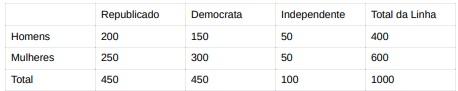

Existe uma diferença entre o eleitores de diferente gênero? As preferências dos
homens se diferem significativamente das preferências das mulheres? Use um nível
de significância de 0.05

H0 - Não há relação entre gênero e preferência eleitoral

HA - Há relação entre gênero e preferência eleitoral

In [20]:
table = [[200, 150, 50],
         [250, 300, 50]]

In [23]:
chi2, p_value, dof, expected = stats.chi2_contingency(observed = table)
print(f'P-valor: {p_value}')

P-valor: 0.0003029775487145488


In [24]:
if p_value < 0.05:
    print('Rejeita a hipótese nula:  Há relação entre gênero e preferência eleitoral')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências que exista relação entre gênero e preferência eleitoral')

Rejeita a hipótese nula:  Há relação entre gênero e preferência eleitoral


## Exercício 4
Enunciado - Precisamos determinar se as meninas, na média, tiram uma nota maior do que 600
na prova. Nós temos a informação de que as meninas tem um desvio padrão de
nota igual a 100.
Então, nós coletamos dados de 20 meninas usando uma amostragem aleatória e
armazenamos na lista abaixo.
Podemos dizer que as meninas, em média, tiram notas maiores que 600?
Assumindo um nível de significância de 0.05.

In [7]:
from statsmodels.stats.weightstats import ztest

H0 - Média das notas = 600

HA - Média das notas > 600

In [25]:
data = [650, 730, 510, 670, 480, 800, 690, 530, 590, 620, 710, 670, 640, 780, 650, 490, 800, 600, 510, 700]

#amostra
alpha = 0.05
sample_avg = np.round( data )
sample_size = len( data )

#população
pop_avg = 600
pop_std = 100

In [29]:
zscore, p_value = ztest(data, value = 600, alternative = 'larger')

print(f'P-value: {p_value}')

P-value: 0.03349471703839336


In [30]:
if p_value < 0.05:
    print('Rejeita a hipótese nula:  A média é maior que 600')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências suficientes que indique que a média seja maior que 600')

Rejeita a hipótese nula:  A média é maior que 600


## Exercício 5

Um farmácia afirma que a média do tempo de entrega dos medicamentos é menor
do que 120 minutos com desvio padrão de 30 minutos.
Foram selecionadas 49 entregas aleatória e o tempo médio essas entregas foi de
100 minutos.
Há evidências suficientes para confirmar a afirmação da farmácia com 0.05 de nível
de significância?

H0 - O tempo médio de entrega é igual a 120

HA - O tempo médio de entrega é menor de 120

In [31]:
alpha = 0.05

sample_mean = 100
sample_size = 49

pop_mean = 120
pop_std = 30

In [37]:
df = np.random.normal(loc=sample_mean, size=sample_size, scale=pop_std)

In [38]:
z_score, p_value = ztest( df, value=120, alternative='smaller')

(-6.211476023208768, 2.6244600509137244e-10)

In [39]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: O tempo médi de entrega é menor que 120')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências suficientes que indique que o tempo médio seja menor que 120')

Rejeita a hipótese nula: O tempo médi de entrega é menor que 120


## Exercício 6

Enunciado - Uma empresa quer melhorar a qualidade dos produtos reduzindo os defeitos e
monitorando a eficiência das linhas de montagem. A linha de montagem A, havia 18
defeitos relatados de 200 amostras selecionadas aleatoriamente, enquanto 25
defeitos de 600 amostras foram relatadas na linha de montagem B.
Há uma diferença entre as linhas de produção em um nível de significância de 0.05?

H0 - A proporção do erro é igual para as duas linhas de montagem

HA - A proporção do erro não é igual para as duas linhas de montagem

In [2]:
# two-tailed two proportion Z-test
success_A = 18
sample_A = 200

success_B = 25
sample_B = 600

In [3]:
success = [success_A, success_B]
samples = [sample_A, sample_B]

In [9]:
z_score, p_value = proportions_ztest(count=success, nobs=samples, alternative='two-sided')
print(f'P-value{p_value}')

P-value0.008669375420073044


In [10]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: A proorção do erro não é igual para as duas linhas de montagem')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências suficientes que indique que a proporção do erro não é igual nas duas linhas de montagem')

Rejeita a hipótese nula: A proorção do erro não é igual para as duas linhas de montagem


## Exercício 7
Enunciado - Pesquisadores gostariam de saber se o estado civil está associado com o nível de
educação. Para isso, eles entrevistaram 300 pessoas aleatoriamente e obtiveram os
seguintes resultados: <br>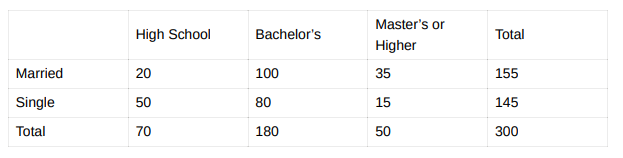

H0 - Não há dependência entre o estado civil e o nível de escolaridade.

HA - Há dependência entre o estado civil e o nível de escolaridade.

In [11]:
#chi-squared test of independence
table = [[20, 100, 35],
         [50, 80, 15]]

In [13]:
chi2, p_value, dof, expect = stats.chi2_contingency( table )
print(f'P-value{p_value}')

P-value1.1357109599633353e-05


In [14]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: Há dependência entre o estado civil e o nível de escolaridade.')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências suficientes que há dependência entre o estado civil e o nível de escolaridade.')

Rejeita a hipótese nula: Há dependência entre o estado civil e o nível de escolaridade.


## Exercício 8
Enunciado - O dono da loja afirma que um número igual de clientes visitam a sua loja cada dia
da semana. Para testar essa hipótese, um Cientista de Dados registrou um número
de clientes que visitaram a loja em uma determina semana e encontrou os seguinte
números:<br>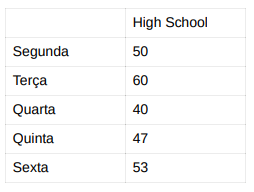
<br>Os dados são consistentes com a afirmação do dono da loja?

H0 - O número de visitantes da loja é igual em todos os dias da semana.

HA - O número de visitantes da loja não é igual em todos os dias da semana.

In [15]:
# chi-squared test of independence
observed = [50, 60, 40, 47, 53]
expect = [50, 50, 50, 50, 50]

In [16]:
chi2, p_value = stats.chisquare( f_obs=observed, f_exp=expect)
print(f'P-value {p_value}')

P-value 0.3594720674366307


In [17]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: O número de visitantes da loja não é igual em todos os dias da semana.')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências suficientes que o número de visitantes da loja não é igual em todos os dias da semana..')

Falha em rejeitar a hipótese nula: Não há evidências suficientes que o número de visitantes da loja não é igual em todos os dias da semana..


## Exercício 9

Professores de uma universidade desenvolveram 3 tipos de métodos de aprendizagem: método cíclico, método linear e o método pirâmide, para ajudar a performance dos alunos em um importante exame.
Para testar se os três diferentes tipos de aprendizagem impactam na performance dos estudantes, os professores atribuírm aleatoriamente 30 estudantes para aprender um dos métodos de aprendizagem, durante as 3 semanas de preparação todos os estudantes realizaram o mesmo teste e o resultado de suas pontuações são mostrados abaixo.
Determine se a pontuação média é a mesma para todos os 3 grupos. 

In [22]:
ciclico = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
linear = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
piramide = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

H0 - Não há diferença significativa da média dos três grupos.

HA - Há diferença significativa da média dos três grupos.

In [32]:
# one-way ANOVA
from scipy.stats import f_oneway
import pandas as pd
import seaborn as sns

In [24]:
statistic, p_value = f_oneway(ciclico, linear, piramide)
print(f'P-value {p_value}')

P-value 0.11384795345837218


In [25]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: Há diferença significativa da média dos três grupos')
else:
    print('Falha em rejeitar a hipótese nula: Não há evidências suficientes que há diferença significativa da média dos três grupos.')

Falha em rejeitar a hipótese nula: Não há evidências suficientes que há diferença significativa da média dos três grupos.


# 7.0 Teste das premissas

1. Variância: A variância das amostras precisam ser iguais
    1. Boxplot
    2. Teste


2. Normalidade: A população origem das amostras precisam ser normalmente distribuídas
    1. Distribuição
    2. Q-Q plot
    3. Shapiro-Wilk


3. Independência entre as amostras
    1. Processo de escolha das amostras deve ser aleatório.

## Premissa 1 - Variância das amostras são iguais

In [31]:
df_ciclico = pd.DataFrame({'método': ['ciclico' for i in range( len(ciclico))], 'value': ciclico})
df_linear = pd.DataFrame({'método': ['linear' for i in range( len(linear))], 'value': linear})
df_piramide = pd.DataFrame({'método': ['piramide' for i in range( len(piramide))], 'value': piramide})

df = pd.concat([df_ciclico, df_linear, df_piramide])
df

,método,value
0,ciclico,85
1,ciclico,86
2,ciclico,88
3,ciclico,75
4,ciclico,78
5,ciclico,94
6,ciclico,98
7,ciclico,79
8,ciclico,71
9,ciclico,80


### boxplot

<AxesSubplot:xlabel='método', ylabel='value'>

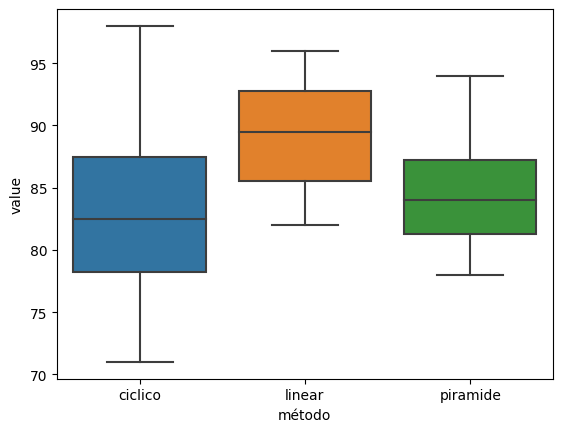

In [33]:
sns.boxplot( x='método', y='value', data=df )

### Bartlett's test

In [50]:
from scipy.stats import bartlett, shapiro, kruskal
#H0: A variância é igual para todas as amostras
#HA: A variância não é igual para um par ou mais de amostras
static, p_value = bartlett( ciclico, linear, piramide )
print(f'P-value {p_value}')

P-value 0.19181598314035977


In [43]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: A variância não é igual para um par ou mais de amostras')
else:
    print('Falha em rejeitar a hipótese nula: Há evidências suficientes que a variância é igual para todas as amostras.')

Falha em rejeitar a hipótese nula: Há evidências suficientes que a variância é igual para todas as amostras.


## Premissa 2 - Normalidade

In [44]:
#H0: População normalmente distribuída
#HA: População não é normamlmente distribuída
static, p_value = shapiro( df['value'])
print(f'P-value: {p_value}')

P-value: 0.8451867699623108


In [46]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: A população não é normalmente distribuída')
else:
    print('Falha em rejeitar a hipótese nula: Há evidências suficientes que a população é normalmente distribuída.')

Falha em rejeitar a hipótese nula: Há evidências suficientes que a população é normalmente distribuída.


### QQplot

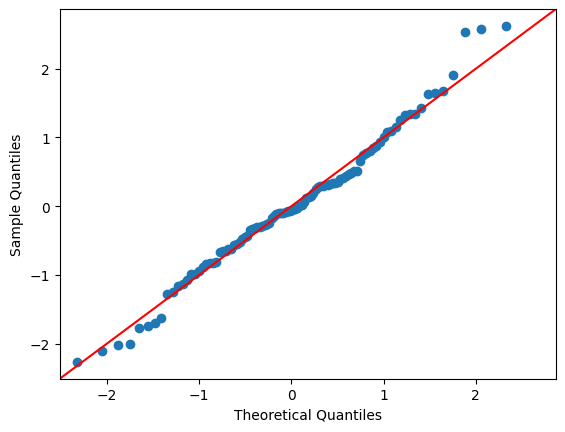

In [48]:
import numpy as np
import statsmodels.api as sm
import pylab as py

data_points = np.random.normal(0, 1, 100)

sm.qqplot(data_points, fit=True, line = '45')
py.show()

1. Premissa de Normalidade Satisfeita
2. Premissa de Variância Satisfeita
3. Premissa de Independência Satisfeita

## Kruskal-Wallis test - Para violação das premissas do Chi-Squared

In [52]:
#HO: Mediana das populações são iguais
#HA: Mediana das populações não são iguais
statistic, p_value = kruskal(ciclico, linear, piramide)
print(f'P-value: {p_value}')

P-value: 0.11876377341727391


In [53]:
if p_value < 0.05:
    print('Rejeita a hipótese nula: Mediana das populações não são iguais')
else:
    print('Falha em rejeitar a hipótese nula: Há evidências suficientes que a mediana das populações são iguais.')

Falha em rejeitar a hipótese nula: Há evidências suficientes que a mediana das populações são iguais.
